In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None

import sqlite3
from dotenv import load_dotenv

load_dotenv()
import os

DB_PATH = os.getenv("DB_PATH")
DATA_PATH = "data"

conn = sqlite3.connect(DB_PATH)

In [120]:
df_score_region = pd.read_csv('../immaterial_index/results/df_region_score.csv', index_col = [0])
df_score_region.sample(5)


,region_name,decade,score
762,Chinese world,270,5
3432,Norway,1710,3
4237,Southern Italy,1380,4
400,Balkans,1040,1
3910,Southern China,870,2


In [121]:
df_unseen_model = pd.read_csv('../unseen_species_model/results/estimations.csv')
df_unseen_model = df_unseen_model[df_unseen_model['decade']<=1880]

df_score_region = pd.read_csv('../immaterial_index/results/df_region_score.csv', index_col=[0])
df_score_region = df_score_region.rename(columns = {'region_name':'region'})

new_df = pd.merge(df_unseen_model, df_score_region, on = ['decade', 'region'])
new_df = new_df.rename(columns = {'region':'region_name', 'decade':'year'})

#new_df['year'] = new_df['year'].astype(int)
#new_df['year'] = new_df['year'].apply(lambda x: round(x/10)*10)
#new_df = new_df.groupby(['region_name', 'year']).mean().reset_index()
#new_df = new_df[new_df['year']<=1840]


#new_df = new_df[~new_df['N_est'].isna()]
# When there is no individuals for the 'score' index, replace by 0
#new_df = new_df.fillna(0)


### Load GDP and Population Data

In [122]:
#df_region_code = pd.read_sql_query("SELECT * FROM region_code", conn)
df_region_code = pd.read_csv("../environnement_data/region_code.csv", index_col = [0])

#df_gdp = pd.read_sql_query("SELECT * FROM gdp", conn)
df_gdp = pd.read_csv("../environnement_data/gdp.csv", index_col=[0])

df_gdp = df_gdp.drop(['country_code_maddison'], axis=1)
df_gdp = df_gdp[df_gdp['year']<=1880]
df_gdp = pd.merge(df_gdp, df_region_code, on = 'region_code')
df_gdp.sample(5)

#df_gdp_clean =  pd.read_sql_query("SELECT * FROM gdp_clean", conn)
df_gdp_clean = pd.read_csv("../environnement_data/gdp_clean.csv", index_col=[0])

df_gdp_clean = pd.merge(df_gdp_clean, df_region_code, on = 'region_code')

In [123]:
#df_population = pd.read_sql_query("SELECT * FROM population", conn)
df_population = pd.read_csv("../environnement_data/population.csv", index_col=[0])

df_population = pd.merge(df_population, df_region_code, on = 'region_code')
df_population = df_population.drop('region_code', axis=1)
df_population.sample(5)


,year,population,region_name
6836,-90,9.220029,Northwestern Europe
2402,940,5.211000,Eastern Europe
3357,-550,1.750000,Greece
2808,-520,1.385000,German world
5032,600,3.500000,Italy


In [124]:
def interpolate_function(df, value="value", category="region_code", year="year", size_interpolation = 10):
    df_interpolated_list = []
    for reg in set(df[category]):
        res = df[df[category] == reg]

        min_date = min(res["year"])
        max_date = max(res["year"])

        year_range = np.arange(round(min_date), round(max_date), size_interpolation)
        df_year = pd.DataFrame(year_range, columns=[year]).reset_index(drop=True)

        res = pd.merge(res, df_year, on=year, how="outer")
        res[category] = reg
        res = res.sort_values(year, ascending=True)
        res[f"{value}_interpolated"] = res[value].interpolate(method="linear")
        res = res.reset_index(drop=True)
        res = res[~res[f"{value}_interpolated"].isna()]

        df_interpolated_list.append(res)

    df_interpolated = pd.concat([x for x in df_interpolated_list])
    df_interpolated = df_interpolated.reset_index(drop=True)
    df_interpolated = df_interpolated.drop(value, axis=1)

    return df_interpolated

df_population_interpolation = interpolate_function(df_population, 
                                                   value = 'population', 
                                                   year = 'year', 
                                                   category="region_name",
                                                   size_interpolation = 10)

In [125]:
max(df_gdp.year)

1880

In [126]:
# Linear interpolation on the proxies in order to merge with the GDP data excatly (that are at the year level)

final = pd.merge(df_population_interpolation, new_df, on = ['region_name', 'year'])
final['score_cap'] = final['score']/final['population_interpolated']
final['lower_cap'] = final['lower']/final['population_interpolated']
final['N_est_cap'] = final['N_est']/final['population_interpolated']
final['upper_cap'] = final['upper']/final['population_interpolated']

data_stats = pd.merge(final, df_gdp, on = ['region_name', 'year'])
data_stats.to_csv(f'results/data_stats.csv')

df_stats_clean = pd.merge(final, df_gdp_clean, on = ['region_name', 'year'])
df_stats_clean.to_csv(f'results/data_stats_clean_gdp.csv')

In [127]:
df_stats_clean.sample(5)

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap,region_code,country_code_maddison,gdp_per_capita
13,1810,Nordic countries,3.853,8157.352081,7528.471725,8828.466121,282,73.189722,1953.924663,2117.143027,2291.322637,re_nordic_countries,SWE,1320
5,1830,Low countries,6.600,8201.784429,7559.061266,8849.375364,363,55.000000,1145.312313,1242.694611,1340.814449,re_low_countries,NLD,3038
8,1810,Italy,20.200,15948.407187,14656.110934,17264.374553,437,21.633663,725.550046,789.525108,854.672008,re_italy,ITA,2558
1,1830,Eastern Europe,36.000,38990.968413,36589.619093,41512.183895,959,26.638889,1016.378308,1083.082456,1153.116219,re_eastern_europe,POL,942
12,1850,Italy,25.000,12778.325722,11097.788797,14574.788229,944,37.760000,443.911552,511.133029,582.991529,re_italy,ITA,2611


In [128]:
years = np.arange(-1000, 1881, 1)

print(len(final))

concat_list = []

for region in final.region_name.unique():
    df_years = pd.DataFrame(years, columns = ['year'])
    df_years['region_name'] = region
    
    final_filtered = final[final['region_name']==region]
    mix = pd.merge(df_years, final_filtered, on = ['year', 'region_name'], how = 'outer')
    concat_list.append(mix)
    
new_final = pd.concat(concat_list)
new_final = new_final.sort_values(['region_name', 'year'])

new_final = new_final.set_index('year')
grouped = new_final.groupby('region_name')

interpolated_data = []
for name, group in grouped:
    interpolated_group = group.interpolate(method='linear')
    interpolated_data.append(interpolated_group)

# Concatenate the interpolated data for all regions
interpolated_df = pd.concat(interpolated_data)

# Reset the index to restore the 'year' column
interpolated_df = interpolated_df.reset_index()
interpolated_df = interpolated_df.drop_duplicates().dropna().reset_index(drop=True)

1686


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_29188/1381052388.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_group = group.interpolate(method='linear')
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_29188/1381052388.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_group = group.interpolate(method='linear')
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_29188/1381052388.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_group = group.interpolate(method='linear')
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_29188/13

In [129]:
data_stats_interpolated = pd.merge(interpolated_df, df_gdp, on = ['region_name', 'year'])
data_stats_interpolated = data_stats_interpolated.reset_index(drop=True)
data_stats_interpolated.to_csv(f'results/data_stats_interpolated.csv')

data_stats_interpolated_clean_gdp = pd.merge(interpolated_df, df_gdp_clean, on = ['region_name', 'year'])
data_stats_interpolated_clean_gdp = data_stats_interpolated_clean_gdp.reset_index(drop=True)
data_stats_interpolated_clean_gdp.to_csv(f'results/data_stats_interpolated_clean_gdp.csv')

In [130]:
max(data_stats_interpolated.year)

1880

In [131]:


import statsmodels.api as sm

def plot_trend(decades, scores, N_est, lower, upper, color="C0", label=None, ax=None, logy=False, figsize=None, lowess = True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if lowess:
        
            # Add LOWESS regression lines
        lowess_scores = sm.nonparametric.lowess(scores, decades, frac=lowess_span)
        ax.plot(decades, lowess_scores[:, 1], color='black', label='LOWESS Scores')

        lowess_lower = sm.nonparametric.lowess(lower, decades, frac=lowess_span)
        lowess_upper = sm.nonparametric.lowess(upper, decades, frac=lowess_span)

        lowess_N_est = sm.nonparametric.lowess(N_est, decades, frac=lowess_span)
        ax.plot(decades, lowess_N_est[:, 1], color="C0", label='LOWESS N_est')

        ax.fill_between(decades, lowess_lower[:, 1], lowess_upper[:, 1], alpha=0.4, color=color)

    else:
        # Plot predicted line
        ax.plot(decades, N_est, color=color, label='Estimated diversity')
        ax.plot(decades, scores, color='black', label='Raw index')

    # Plot credibility bands
        #ax.fill_between(decades, lower, upper, alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Number of Individuals")
    if logy:
        ax.set_yscale("log")
        
    ax.set_title(label)
    ax.legend()

    return ax



(-500.0, 1880.0)

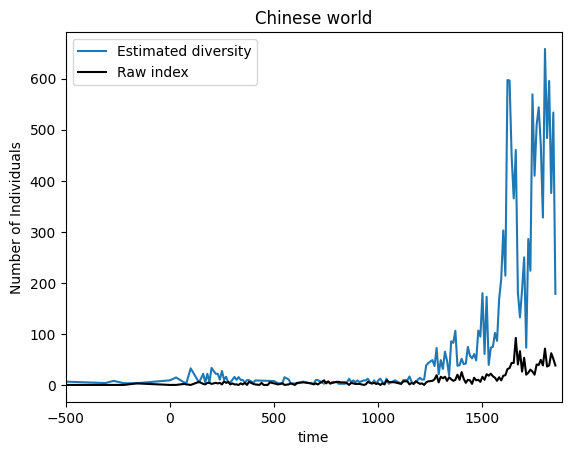

In [133]:
lowess_span = 0.05

region = 'Chinese world'

df = new_df[new_df['region_name']==region]

N_est = list(df['N_est'])
lower = list(df['lower'])
upper = list(df['upper'])
decades = list(df['year'])
scores = list(df['score'])

ax = plot_trend(decades, scores, N_est, lower, upper, label=region, logy = False, lowess = False)
ax.set_xlim(-500, 1880)